# Import Stuff

In [3]:
import os
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import onnx
import onnxruntime

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

from matching import matching
from evaluation.metrics import createPR, recallAt100precision, recallAtK
from datasets.load_dataset import GardensPointDataset, SFUDataset, StLuciaDataset

# conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
# conda install onnx onnxruntime
# pip install torch torchvision numpy opencv-python seaborn matplotlib scikit-learn pillow onnxscript

# Load Datasets

In [4]:
# imgs_db, imgs_q, GThard, GTsoft = SFUDataset().load()
# imgs_db, imgs_q, GThard, GTsoft = GardensPointDataset().load()
imgs_db, imgs_q, GThard, GTsoft = StLuciaDataset().load()

===== Load dataset StLucia 100909_0845--180809_1545 (small version)


# Constants

In [5]:
WEIGHTS_FILE = "calc.caffemodel.pt"
ITERATIONS = 100

# Model Definition

In [6]:
class CalcModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_dim = (1, 120, 160)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(5, 5), stride=2, padding=4)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=1, padding=2)
        self.conv3 = nn.Conv2d(128, 4, kernel_size=(3, 3), stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=2)
        self.lrn1 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        self.lrn2 = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.lrn1(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.lrn2(x)

        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)
        return x

### Normal Model

In [7]:
calc = CalcModel()

# Load the model weights
state_dict = torch.load(WEIGHTS_FILE)
my_new_state_dict = {}
my_layers = list(calc.state_dict().keys())
for layer in my_layers:
    my_new_state_dict[layer] = state_dict[layer]
calc.load_state_dict(my_new_state_dict)

<All keys matched successfully>

### ONNX Model

In [8]:
example_input = torch.randn(1, 1, 120, 160)

dynamic_axes = {"input": {0: "batch_size"}, "output": {0: "batch_size"}}

# Export the model
torch.onnx.export(
    calc,  # model
    example_input,  # example input
    "calc_model.onnx",  # output file name
    input_names=["input"],  # input names
    output_names=["output"],  # output names
    dynamic_axes=dynamic_axes,  # dynamic axes
)

c:\Users\Irfan Q\miniconda3\envs\bruh\Lib\site-packages\torch\onnx\_internal\jit_utils.py:307: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
c:\Users\Irfan Q\miniconda3\envs\bruh\Lib\site-packages\torch\onnx\utils.py:702: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\jit\passes\onnx\constant_fold.cpp:181.)
  _C._jit_pass_onnx_graph_shape_type_inference(
c:\Users\Irfan Q\miniconda3\envs\bruh\Lib\site-packages\torch\onnx\utils.py:1209: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Trigg

### CUDA Model

In [9]:
torch.cuda.is_available()

# Instantiate the Model
calc_cuda = CalcModel().half().cuda()

# Load the model weights
state_dict = torch.load(WEIGHTS_FILE)
my_new_state_dict = {}
my_layers = list(calc_cuda.state_dict().keys())
for layer in my_layers:
    my_new_state_dict[layer] = state_dict[layer]
calc_cuda.load_state_dict(my_new_state_dict)

<All keys matched successfully>

# Preprocess Images

In [10]:
class ConvertToYUVandEqualizeHist:
    def __call__(self, img):
        img_yuv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2YUV)
        img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
        img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return Image.fromarray(img_rgb)

preprocess = transforms.Compose(
    [
        ConvertToYUVandEqualizeHist(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((120, 160), interpolation=Image.BICUBIC),
        transforms.ToTensor(),
    ]
)

In [11]:
# Preprocess query images

query_matrix = []

for image in imgs_db:
    preprocessed_image = preprocess(image)
    query_matrix.append(preprocessed_image)

query_matrix = np.stack(query_matrix, axis=0)

# Convert numpy array to a tensor
query_tensor = torch.from_numpy(query_matrix)

print(query_tensor.shape)
print(query_tensor)

torch.Size([200, 1, 120, 160])
tensor([[[[0.5569, 0.5569, 0.5804,  ..., 0.2706, 0.2353, 0.2314],
          [0.5569, 0.5569, 0.5843,  ..., 0.2627, 0.2196, 0.2235],
          [0.6157, 0.6196, 0.6392,  ..., 0.1922, 0.2078, 0.2745],
          ...,
          [0.6824, 0.7216, 0.6941,  ..., 0.1216, 0.1922, 0.2000],
          [0.6706, 0.6667, 0.6392,  ..., 0.1059, 0.1686, 0.1725],
          [0.6235, 0.5333, 0.5333,  ..., 0.1137, 0.2353, 0.2471]]],


        [[[0.6784, 0.4392, 0.2784,  ..., 0.6431, 0.6157, 0.5765],
          [0.7176, 0.4941, 0.2902,  ..., 0.6353, 0.6588, 0.6196],
          [0.6941, 0.5098, 0.3647,  ..., 0.6353, 0.6235, 0.6196],
          ...,
          [0.5294, 0.5333, 0.5333,  ..., 0.3765, 0.3255, 0.3216],
          [0.5529, 0.5529, 0.5725,  ..., 0.3961, 0.4078, 0.4118],
          [0.5529, 0.5569, 0.5765,  ..., 0.3412, 0.4078, 0.4118]]],


        [[[0.4039, 0.3961, 0.4078,  ..., 0.9608, 0.8980, 0.8902],
          [0.4000, 0.3843, 0.3020,  ..., 0.9608, 0.9020, 0.8863],
       

In [12]:
# Preprocess map images

map_matrix = []

for image in imgs_q:
    preprocessed_image = preprocess(image)
    map_matrix.append(preprocessed_image)

map_matrix = np.stack(map_matrix, axis=0)

# Convert numpy array to a tensor
map_tensor = torch.from_numpy(map_matrix)

print(map_tensor.shape)
print(map_tensor)

torch.Size([200, 1, 120, 160])
tensor([[[[0.6863, 0.6510, 0.5843,  ..., 0.4000, 0.4235, 0.4235],
          [0.5333, 0.4784, 0.5294,  ..., 0.4157, 0.4824, 0.4824],
          [0.5451, 0.5098, 0.4980,  ..., 0.4824, 0.5137, 0.4706],
          ...,
          [0.0235, 0.0235, 0.0235,  ..., 0.6627, 0.5882, 0.5294],
          [0.0235, 0.0235, 0.0157,  ..., 0.5725, 0.4902, 0.3686],
          [0.0235, 0.0235, 0.0157,  ..., 0.4588, 0.2667, 0.2353]]],


        [[[0.6196, 0.6196, 0.6235,  ..., 0.9686, 0.9216, 0.9176],
          [0.6196, 0.6196, 0.6235,  ..., 0.8706, 0.9255, 0.9176],
          [0.6235, 0.6235, 0.6235,  ..., 0.8353, 0.8706, 0.9490],
          ...,
          [0.0471, 0.0510, 0.0745,  ..., 0.6863, 0.7059, 0.7098],
          [0.0706, 0.0706, 0.0549,  ..., 0.6745, 0.6667, 0.6902],
          [0.0706, 0.0706, 0.0471,  ..., 0.6745, 0.6627, 0.6902]]],


        [[[0.7529, 0.7529, 0.7569,  ..., 0.3686, 0.3686, 0.4745],
          [0.7529, 0.7529, 0.7569,  ..., 0.5686, 0.5216, 0.6314],
       

# Run Models

### Normal Model

In [13]:
query_tensor = torch.from_numpy(query_matrix)
map_tensor = torch.from_numpy(map_matrix)

print(query_tensor.shape)
print(map_tensor.shape)

query_tensor = query_tensor.view(-1, 1, 120, 160)
map_tensor = map_tensor.view(-1, 1, 120, 160)

# Pass the tensors through the model

query_features = calc(query_tensor)
map_features = calc(map_tensor)

print(query_features.shape)
print(map_features.shape)

torch.Size([200, 1, 120, 160])
torch.Size([200, 1, 120, 160])
torch.Size([200, 936])
torch.Size([200, 936])


In [14]:
# Convert pytorch tensors to numpy arrays
query_features_np = query_features.detach().numpy()
map_features_np = map_features.detach().numpy()

similarity_matrix = cosine_similarity(query_features_np, map_features_np)

print(similarity_matrix.shape)

(200, 200)


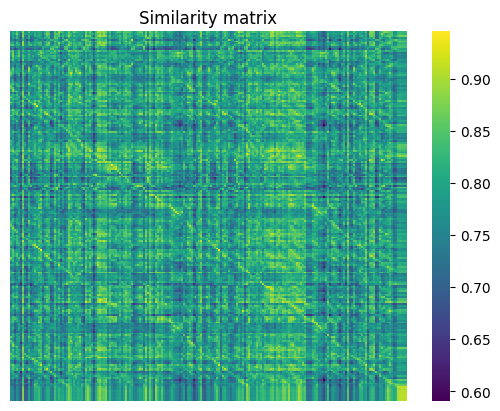

In [15]:
plt.figure()
sns.heatmap(similarity_matrix, cmap='viridis')
plt.title('Similarity matrix')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Thresholding S>=thresh')

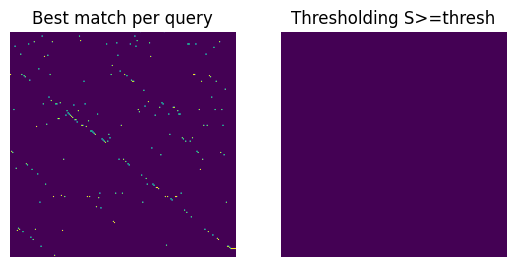

In [16]:
# best matching per query in S for single-best-match VPR
M1 = matching.best_match_per_query(similarity_matrix)

# find matches with S>=thresh using an auto-tuned threshold for multi-match VPR
M2 = matching.thresholding(similarity_matrix, 'auto')

TP = np.argwhere(M2 & GThard)  # true positives
FP = np.argwhere(M2 & ~GTsoft)  # false positives

# show M's
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(M1)
ax1.axis('off')
ax1.set_title('Best match per query')
ax2 = fig.add_subplot(122)
ax2.imshow(M2)
ax2.axis('off')
ax2.set_title('Thresholding S>=thresh')

### ONNX Model

In [17]:
# Check if model is a valid ONNX model
onnx_model = onnx.load("calc_model.onnx")
onnx.checker.check_model(onnx_model)

In [18]:
# Convert the tensors to numpy arrays
query_numpy = query_tensor.detach().cpu().numpy()
map_numpy = map_tensor.detach().cpu().numpy()

ort_session = onnxruntime.InferenceSession("calc_model.onnx")

In [19]:
# Get the input name from the model
input_name = ort_session.get_inputs()[0].name

# Ensure the inputs are numpy arrays
query_numpy = np.array(query_numpy)
map_numpy = np.array(map_numpy)

# Create the input dictionary
ort_query_input = {input_name: query_numpy}

# Run the model
ort_query_output = ort_session.run(None, ort_query_input)

# Convert the output to a numpy array and print its shape
ort_query_output = np.array(ort_query_output)
print(ort_query_output.shape)

# Create the input dictionary
ort_map_input = {input_name: map_numpy}

# Run the model
ort_map_output = ort_session.run(None, ort_map_input)

# Convert the output to a numpy array and print it
ort_map_output = np.array(ort_map_output)
print(ort_map_output.shape)

(1, 200, 936)
(1, 200, 936)


In [20]:
ort_query_output = np.squeeze(ort_query_output)
print(ort_query_output.shape)
ort_map_output = np.squeeze(ort_map_output)
print(ort_map_output.shape)

(200, 936)
(200, 936)


### CUDA Model

In [21]:
# Pass the tensors through the model

query_features = calc_cuda(query_tensor.half().cuda())
map_features = calc_cuda(map_tensor.half().cuda())

query_features_cpu = query_features.detach().cpu()
map_features_cpu = map_features.detach().cpu()

print(query_features_cpu.shape)
print(map_features_cpu.shape)

torch.Size([200, 936])
torch.Size([200, 936])


# Average Time

### Normal Model

In [22]:
start_time = time.time()

for _ in range(ITERATIONS):
    output = calc(query_tensor)

end_time = time.time()

query_duration_calc = end_time - start_time
query_avg_duration_calc = query_duration_calc / ITERATIONS

print(f"Time taken: {query_duration_calc} seconds")
print(f"Average time taken: {query_avg_duration_calc} seconds")

# Average time for map tensor

start_time = time.time()

for _ in range(ITERATIONS):
    with torch.no_grad():
        output = calc(map_tensor)

end_time = time.time()

map_duration_calc = end_time - start_time
map_avg_duration_calc = map_duration_calc / ITERATIONS

print(f"Time taken: {map_duration_calc} seconds")
print(f"Average time taken: {map_avg_duration_calc} seconds")

Time taken: 26.567658185958862 seconds
Average time taken: 0.26567658185958865 seconds
Time taken: 23.250080347061157 seconds
Average time taken: 0.23250080347061158 seconds


### ONNX Model

In [23]:
# Average time for query tensor

input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: query_numpy}

start_time = time.time()

for _ in range(ITERATIONS):
    ort_outs = ort_session.run(None, ort_inputs)

end_time = time.time()

query_duration_onnx = end_time - start_time
query_avg_duration_onnx = query_duration_onnx / ITERATIONS

print(f"Time taken: {query_duration_onnx} seconds")
print(f"Average time taken: {query_avg_duration_onnx} seconds")

# Average time for map tensor

input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: map_numpy}

start_time = time.time()

for _ in range(ITERATIONS):
    ort_outs = ort_session.run(None, ort_inputs)

end_time = time.time()

map_duration_onnx = end_time - start_time
map_avg_duration_onnx = map_duration_onnx / ITERATIONS

print(f"Time taken: {map_duration_onnx} seconds")
print(f"Average time taken: {map_avg_duration_onnx} seconds")

Time taken: 14.263883829116821 seconds
Average time taken: 0.14263883829116822 seconds
Time taken: 14.431385278701782 seconds
Average time taken: 0.14431385278701783 seconds


### CUDA Model

In [24]:
start_time = time.time()

for _ in range(ITERATIONS):
    output = calc_cuda(query_tensor.half().cuda())

end_time = time.time()

query_duration_cuda = end_time - start_time
query_avg_duration_cuda = query_duration_cuda / ITERATIONS

print(f"Time taken: {query_duration_cuda} seconds")
print(f"Average time taken: {query_avg_duration_cuda} seconds")

# Average time for map tensor

start_time = time.time()

for _ in range(ITERATIONS):
    output = calc_cuda(map_tensor.half().cuda())

end_time = time.time()

map_duration_cuda = end_time - start_time
map_avg_duration_cuda = map_duration_cuda / ITERATIONS

print(f"Time taken: {map_duration_cuda} seconds")
print(f"Average time taken: {map_avg_duration_cuda} seconds")

Time taken: 1.4909439086914062 seconds
Average time taken: 0.014909439086914063 seconds
Time taken: 1.4357807636260986 seconds
Average time taken: 0.014357807636260987 seconds


# Evaluation

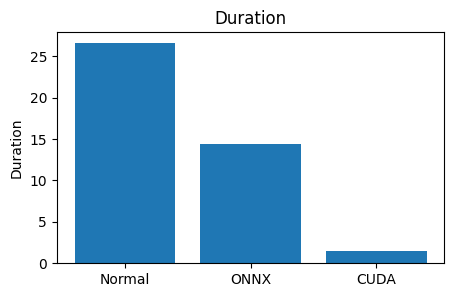

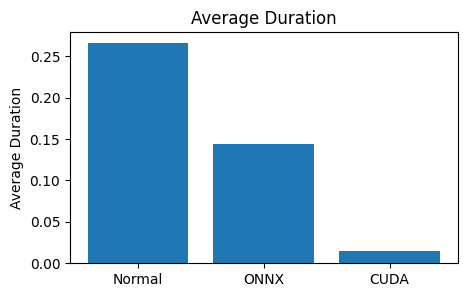

In [25]:
import matplotlib.pyplot as plt

# Variables
models = ['Normal', 'ONNX', 'CUDA']
durations = [query_duration_calc, map_duration_onnx, map_duration_cuda]
avg_durations = [query_avg_duration_calc, map_avg_duration_onnx, map_avg_duration_cuda]

# Plot duration bar chart
plt.figure(figsize=(5, 3))
plt.bar(models, durations)
plt.title('Duration')
plt.ylabel('Duration')
plt.show()

# Plot average duration bar chart
plt.figure(figsize=(5, 3))
plt.bar(models, avg_durations)
plt.title('Average Duration')
plt.ylabel('Average Duration')
plt.show()

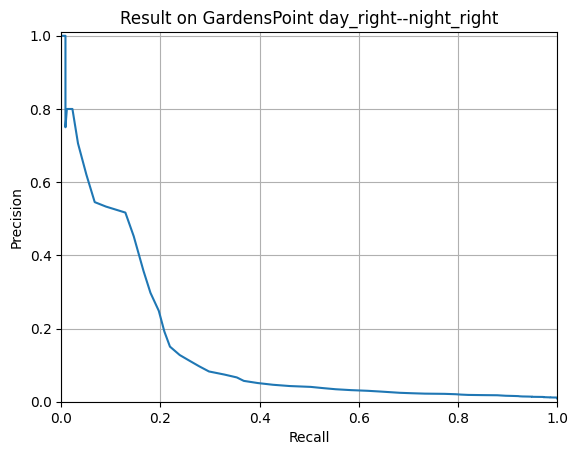

In [26]:
# precision-recall curve
P, R = createPR(similarity_matrix, GThard, GTsoft, matching='multi', n_thresh=100)
plt.figure()
plt.plot(R, P)
plt.xlim(0, 1), plt.ylim(0, 1.01)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Result on GardensPoint day_right--night_right')
plt.grid('on')
plt.draw()
plt.show()